## Dipole calculations using events file instead of flux file

In [2]:
import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt

# Load the event file
data = ascii.read("../data/Auger/events_a8_lb.dat")

# Extract columns
RA = np.deg2rad(data['RA'])          # RA in radians
dec = np.deg2rad(data['dec'])        # Dec in radians
azimuth = np.deg2rad(data['azimuth'])  # Azimuth in radians
weights = data['weight']             # Provided event weights

# Total normalized weight
W = np.sum(weights)

# --- 2D Dipole: Rayleigh analysis in RA ---
a_alpha = (2.0 / W) * np.sum(weights * np.cos(RA))
b_alpha = (2.0 / W) * np.sum(weights * np.sin(RA))

r_alpha = np.sqrt(a_alpha**2 + b_alpha**2)
phi_alpha = np.arctan2(b_alpha, a_alpha) % (2 * np.pi)
phi_alpha_deg = np.rad2deg(phi_alpha)

print("=== 2D Dipole in Right Ascension ===")
print(f"Amplitude (r_alpha): {r_alpha:.4f}")
print(f"Phase (RA): {phi_alpha_deg:.2f}°")

# --- 3D Dipole Reconstruction ---
# Use values from the paper unless zenith is available
mean_cos_dec = np.mean(np.cos(dec))  # <cos δ>
mean_sin_theta = 0.65                # Paper's ⟨sin θ⟩
lat_obs = np.deg2rad(-35.2)          # Observatory latitude

d_perp = r_alpha / mean_cos_dec
b_phi = (2.0 / W) * np.sum(weights * np.sin(azimuth))
d_z = b_phi / (np.cos(lat_obs) * mean_sin_theta)

dipole_amp = np.sqrt(d_perp**2 + d_z**2)
delta_d = np.rad2deg(np.arctan2(d_z, d_perp))
alpha_d = phi_alpha_deg

print("\n=== 3D Dipole ===")
print(f"Dipole amplitude: {dipole_amp:.4f}")
print(f"Dipole direction: RA = {alpha_d:.2f}°, Dec = {delta_d:.2f}°")


=== 2D Dipole in Right Ascension ===
Amplitude (r_alpha): 0.0466
Phase (RA): 100.34°

=== 3D Dipole ===
Dipole amplitude: 0.0652
Dipole direction: RA = 100.34°, Dec = -23.80°


In [3]:
# Compute Neff
W = np.sum(weights)
Weff = W**2 / np.sum(weights**2)
sigma_r = np.sqrt(2 / Weff)
sigma_phi_rad = sigma_r / r_alpha
sigma_phi_deg = np.rad2deg(sigma_phi_rad)

print("=== Analytical Uncertainties ===")
print(f"σ_r_alpha ≈ {sigma_r:.4f} ({sigma_r * 100:.2f}%)")
print(f"σ_phi_alpha ≈ {sigma_phi_deg:.2f}°")


=== Analytical Uncertainties ===
σ_r_alpha ≈ 0.0079 (0.79%)
σ_phi_alpha ≈ 9.69°


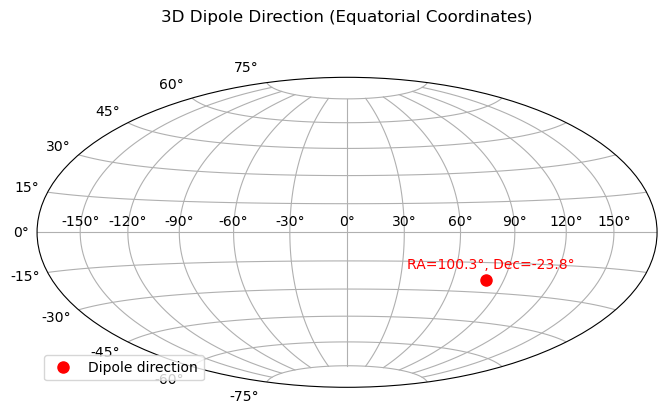

In [4]:
import matplotlib.pyplot as plt

# Convert RA/Dec to radians for plotting
ra_dipole = np.deg2rad(alpha_d)
dec_dipole = np.deg2rad(delta_d)

# Shift RA to [-π, π] for Hammer projection
ra_plot = -(ra_dipole - np.pi)

plt.figure(figsize=(8, 5))
ax = plt.subplot(111, projection='hammer')
ax.grid(True)

# Plot the dipole direction
ax.plot(ra_plot, dec_dipole, 'ro', markersize=8, label='Dipole direction')

# Annotate
ax.text(ra_plot, dec_dipole + 0.1, f'RA={alpha_d:.1f}°, Dec={delta_d:.1f}°', ha='center', color='red')
plt.title("3D Dipole Direction (Equatorial Coordinates)", pad=40)
plt.legend(loc='lower left')
plt.show()


=== Galaxy Dipole Analysis ===
2D amplitude (r_alpha): 0.0772
RA phase: 43.74°
Projected 3D dipole amplitude: 0.0950
Direction: RA = 43.74°, Dec = 0.00°
σ_r_alpha ≈ 0.0130 (1.30%)
σ_phi_alpha ≈ 9.62°
Rayleigh p-value: 1.96e-08
Gaussian significance: 5.49 σ
Angular separation with Auger dipole: 59.51°


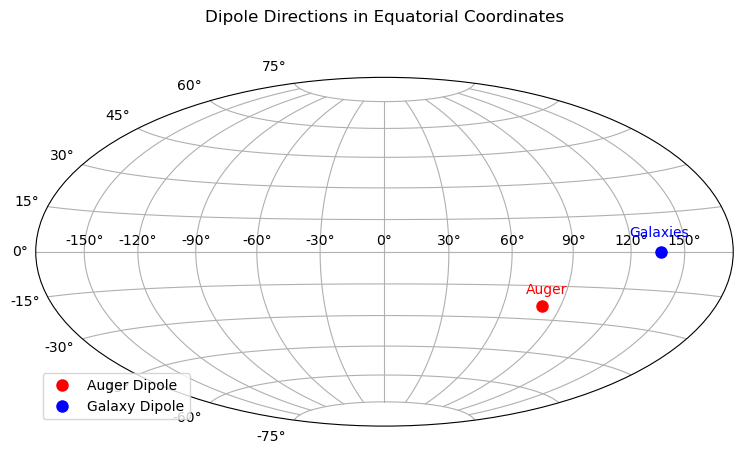

In [6]:
import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.special import erfinv

# === Load Galaxy Catalog ===
galaxies = ascii.read('../data/2MRSxWISE_sinBPTAGNs.txt')  
RA = np.deg2rad(galaxies['_RAJ2000'])
Dec = np.deg2rad(galaxies['_DEJ2000'])
weights = np.ones(len(RA))

# === 2D Rayleigh Dipole in RA ===
W = np.sum(weights)
a_alpha = (2.0 / W) * np.sum(weights * np.cos(RA))
b_alpha = (2.0 / W) * np.sum(weights * np.sin(RA))
r_alpha = np.sqrt(a_alpha**2 + b_alpha**2)
phi_alpha = np.arctan2(b_alpha, a_alpha) % (2 * np.pi)
phi_alpha_deg = np.rad2deg(phi_alpha)

# === Partial 3D Dipole (d_z = 0) ===
mean_cos_dec = np.mean(np.cos(Dec))
d_perp = r_alpha / mean_cos_dec
dipole_amp = d_perp
alpha_d = phi_alpha_deg
delta_d = 0.0

# === Analytical Uncertainties and Significance ===
Weff = W**2 / np.sum(weights**2)
sigma_r = np.sqrt(2 / Weff)
sigma_phi_deg = np.rad2deg(sigma_r / r_alpha)
P_rayleigh = np.exp(-Weff * r_alpha**2 / 4)
Z = np.sqrt(2) * erfinv(1 - 2 * P_rayleigh)

# === Print Results ===
print("=== Galaxy Dipole Analysis ===")
print(f"2D amplitude (r_alpha): {r_alpha:.4f}")
print(f"RA phase: {phi_alpha_deg:.2f}°")
print(f"Projected 3D dipole amplitude: {dipole_amp:.4f}")
print(f"Direction: RA = {alpha_d:.2f}°, Dec = {delta_d:.2f}°")
print(f"σ_r_alpha ≈ {sigma_r:.4f} ({sigma_r*100:.2f}%)")
print(f"σ_phi_alpha ≈ {sigma_phi_deg:.2f}°")
print(f"Rayleigh p-value: {P_rayleigh:.2e}")
print(f"Gaussian significance: {Z:.2f} σ")

# === Auger Dipole ===
auger_RA_deg = 100
auger_Dec_deg = -24

# === Angular Separation ===
dipole_gal = SkyCoord(ra=alpha_d*u.deg, dec=delta_d*u.deg, frame='icrs')
dipole_aug = SkyCoord(ra=auger_RA_deg*u.deg, dec=auger_Dec_deg*u.deg, frame='icrs')
angle_sep = dipole_gal.separation(dipole_aug)

print(f"Angular separation with Auger dipole: {angle_sep.deg:.2f}°")

# === Plotting Both Dipoles ===
# Convert to Hammer projection coordinates
ra_gal_rad = np.deg2rad(alpha_d)
dec_gal_rad = np.deg2rad(delta_d)
ra_aug_rad = np.deg2rad(auger_RA_deg)
dec_aug_rad = np.deg2rad(auger_Dec_deg)

ra_gal_plot = -(ra_gal_rad - np.pi)
ra_aug_plot = -(ra_aug_rad - np.pi)

plt.figure(figsize=(9, 5))
ax = plt.subplot(111, projection="hammer")
ax.grid(True)

ax.plot(ra_aug_plot, dec_aug_rad, 'ro', label="Auger Dipole", markersize=8)
ax.plot(ra_gal_plot, dec_gal_rad, 'bo', label="Galaxy Dipole", markersize=8)

ax.text(ra_aug_plot, dec_aug_rad + 0.1, "Auger", ha='center', color='red')
ax.text(ra_gal_plot, dec_gal_rad + 0.1, "Galaxies", ha='center', color='blue')

plt.title("Dipole Directions in Equatorial Coordinates", pad=40)
plt.legend(loc='lower left')
plt.show()


/tmp/ipykernel_52696/417733474.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', n_bins)



=== Dipole for cz 1200-2200 km/s ===
N = 73 galaxies
RA = 176.34°, Dec = -20.98°
r_alpha = 0.9207, d_perp = 0.0875
σ_r = 0.1655, σ_phi = 10.30°
Significance: 5.08 σ, p = 1.91e-07

=== Dipole for cz 2200-3200 km/s ===
N = 198 galaxies
RA = 186.34°, Dec = -47.82°
r_alpha = 0.5656, d_perp = 0.0875
σ_r = 0.1005, σ_phi = 10.18°
Significance: 5.15 σ, p = 1.33e-07

=== Dipole for cz 3200-4200 km/s ===
N = 333 galaxies
RA = 148.80°, Dec = -26.09°
r_alpha = 0.3417, d_perp = 0.0875
σ_r = 0.0775, σ_phi = 13.00°
Significance: 3.85 σ, p = 6.01e-05

=== Dipole for cz 4200-5200 km/s ===
N = 877 galaxies
RA = 22.70°, Dec = 11.87°
r_alpha = 0.4127, d_perp = 0.0875
σ_r = 0.0478, σ_phi = 6.63°
Significance: 8.29 σ, p = 6.02e-17

=== Dipole for cz 5200-6200 km/s ===
N = 1258 galaxies
RA = 21.91°, Dec = 16.37°
r_alpha = 0.4537, d_perp = 0.0875
σ_r = 0.0399, σ_phi = 5.04°
Significance: inf σ, p = 7.66e-29

=== Dipole for cz 6200-7200 km/s ===
N = 1384 galaxies
RA = 162.68°, Dec = 58.40°
r_alpha = 0.1915, d

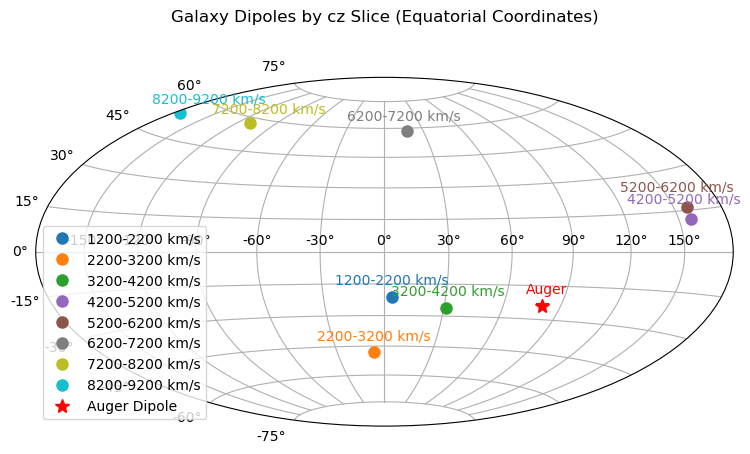

In [11]:
import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.special import erfinv
import matplotlib.cm as cm

# === Load Galaxy Catalog ===
gxs = ascii.read("../data/2MRSxWISE_sinBPTAGNs.txt")  # Update path
RA_all = np.deg2rad(gxs['_RAJ2000'])
Dec_all = np.deg2rad(gxs['_DEJ2000'])
cz_all = gxs['cz']
weights_all = np.ones(len(RA_all))

# === Define cz bins here ===
# You can change this list to customize the slices
# cz_bins = [
#     (1200, 3600),
#     (4000, 5000),
#     (9000, 9400)
# ]
# To cover full range in slices of 1000 km/s:
cz_bins = [(cz, cz + 1000) for cz in range(1200, 9000, 1000)]

# === Setup for plotting and storage ===
n_bins = len(cz_bins)
colors = cm.get_cmap('tab10', n_bins)
dipole_results = {}

# === Loop over cz bins ===
for i, (cz_min, cz_max) in enumerate(cz_bins):
    label = f"{cz_min}-{cz_max} km/s"
    color = colors(i)
    
    # Apply cz mask
    mask = (cz_all > cz_min) & (cz_all < cz_max)
    RA = RA_all[mask]
    Dec = Dec_all[mask]
    weights = weights_all[mask]
    
    if len(RA) < 10:
        print(f"Skipping {label} — too few galaxies ({len(RA)})")
        continue

    # 2D dipole
    W = np.sum(weights)
    a_alpha = (2.0 / W) * np.sum(weights * np.cos(RA))
    b_alpha = (2.0 / W) * np.sum(weights * np.sin(RA))
    r_alpha = np.sqrt(a_alpha**2 + b_alpha**2)
    phi_alpha = np.arctan2(b_alpha, a_alpha) % (2 * np.pi)
    phi_alpha_deg = np.rad2deg(phi_alpha)

    # Compute full 3D dipole direction
    x = np.cos(Dec) * np.cos(RA)
    y = np.cos(Dec) * np.sin(RA)
    z = np.sin(Dec)

    # Weighted sum of unit vectors
    X = np.sum(weights * x)
    Y = np.sum(weights * y)
    Z = np.sum(weights * z)

    # Normalize
    norm = np.sqrt(X**2 + Y**2 + Z**2)
    X /= norm
    Y /= norm
    Z /= norm

    # Dipole amplitude (normalized vector)
    dipole_amp = norm / np.sum(weights)

    # Convert vector back to (RA, Dec)
    alpha_d = (np.arctan2(Y, X) % (2 * np.pi)) * 180/np.pi
    delta_d = np.arcsin(Z) * 180/np.pi


    # Uncertainty and significance
    Weff = W**2 / np.sum(weights**2)
    sigma_r = np.sqrt(2 / Weff)
    sigma_phi_deg = np.rad2deg(sigma_r / r_alpha)
    P_rayleigh = np.exp(-Weff * r_alpha**2 / 4)
    Z = np.sqrt(2) * erfinv(1 - 2 * P_rayleigh)

    # Store
    dipole_results[label] = {
        'RA': alpha_d,
        'Dec': delta_d,
        'r_alpha': r_alpha,
        'd_perp': d_perp,
        'σ_r': sigma_r,
        'σ_phi': sigma_phi_deg,
        'Z': Z,
        'P': P_rayleigh,
        'N': len(RA),
        'color': color
    }

    # Print
    print(f"\n=== Dipole for cz {label} ===")
    print(f"N = {len(RA)} galaxies")
    print(f"RA = {alpha_d:.2f}°, Dec = {delta_d:.2f}°")
    print(f"r_alpha = {r_alpha:.4f}, d_perp = {d_perp:.4f}")
    print(f"σ_r = {sigma_r:.4f}, σ_phi = {sigma_phi_deg:.2f}°")
    print(f"Significance: {Z:.2f} σ, p = {P_rayleigh:.2e}")

# === Plot all dipoles ===
plt.figure(figsize=(9, 5))
ax = plt.subplot(111, projection='hammer')
ax.grid(True)

for label, res in dipole_results.items():
    ra_rad = np.deg2rad(res['RA'])
    dec_rad = np.deg2rad(res['Dec'])
    ra_plot = -(ra_rad - np.pi)
    ax.plot(ra_plot, dec_rad, 'o', color=res['color'], label=label, markersize=8)
    ax.text(ra_plot, dec_rad + 0.1, label, ha='center', color=res['color'])

# Add Auger dipole for reference
auger_ra = np.deg2rad(100)
auger_dec = np.deg2rad(-24)
auger_ra_plot = -(auger_ra - np.pi)
ax.plot(auger_ra_plot, auger_dec, 'r*', markersize=10, label='Auger Dipole')
ax.text(auger_ra_plot, auger_dec + 0.1, "Auger", ha='center', color='red')

plt.title("Galaxy Dipoles by cz Slice (Equatorial Coordinates)", pad=40)
plt.legend(loc='lower left')
plt.show()



=== Dipole for Full Sample ===
N = 8021 galaxies
RA = 17.60° ± 13.30°
Dec = 57.21° ± 13.30°
Amplitude = 0.0599
Significance = 3.74 σ (p = 9.31e-05)
Angular separation from Auger = 106.05°

=== Dipole for 1200-2200 km/s ===
N = 73 galaxies
RA = 176.34° ± 10.30°
Dec = -20.98° ± 10.30°
Amplitude = 0.4135
Significance = 5.08 σ (p = 1.91e-07)
Angular separation from Auger = 69.69°

=== Dipole for 2200-3200 km/s ===
N = 198 galaxies
RA = 186.34° ± 10.18°
Dec = -47.82° ± 10.18°
Amplitude = 0.3276
Significance = 5.15 σ (p = 1.33e-07)
Angular separation from Auger = 70.09°

=== Dipole for 3200-4200 km/s ===
N = 333 galaxies
RA = 148.80° ± 13.00°
Dec = -26.09° ± 13.00°
Amplitude = 0.1542
Significance = 3.85 σ (p = 6.01e-05)
Angular separation from Auger = 44.00°

=== Dipole for 4200-5200 km/s ===
N = 877 galaxies
RA = 22.70° ± 6.63°
Dec = 11.87° ± 6.63°
Amplitude = 0.1729
Significance = 8.29 σ (p = 6.02e-17)
Angular separation from Auger = 83.52°

=== Dipole for 5200-6200 km/s ===
N = 1258 gala

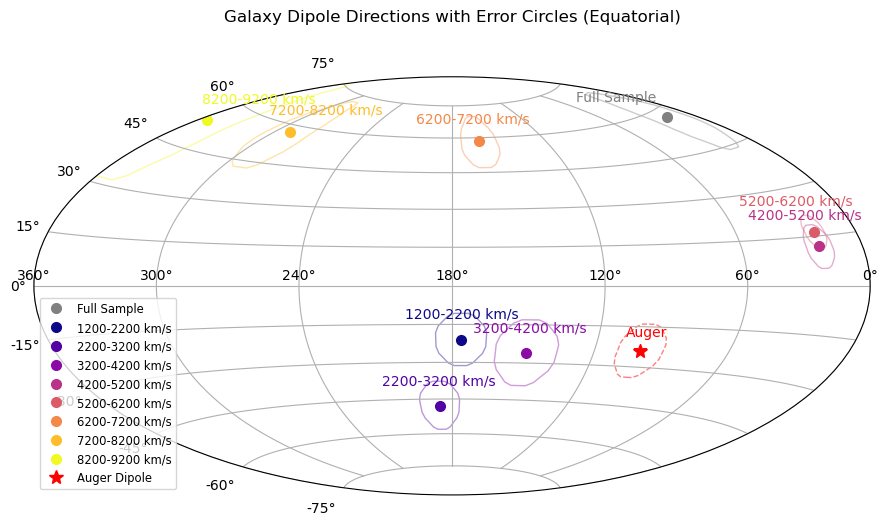

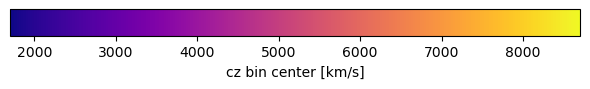

In [ ]:
import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.special import erfinv
import matplotlib.cm as cm
import matplotlib.cm as cm
import matplotlib.colors as mcolors



# === Load galaxy catalogue ===
gxs = ascii.read("../data/2MRSxWISE_sinBPTAGNs.txt")
RA_all = np.deg2rad(gxs['_RAJ2000'])
Dec_all = np.deg2rad(gxs['_DEJ2000'])
cz_all = gxs['cz']
weights_all = np.ones(len(RA_all))

# === Define cz bins ===
cz_bins = [
    (1200, 9000),       # Full sample
    (1200, 3600),
    (4000, 5000),
    (9000, 9400)
]
cz_bins = [(cz, cz + 1000) for cz in range(1200, 9000, 1000)]
cz_bins.insert(0, (1200, 9000))  # Add full sample as first bin

# === Setup colors and storage ===
n_bins = len(cz_bins)
#colors = cm.get_cmap('tab10', n_bins)
dipole_results = {}
# Normalize cz range for colormap
cz_vals = [0.5 * (cz_min + cz_max) for (cz_min, cz_max) in cz_bins]
cz_norm = mcolors.Normalize(vmin=min(cz_vals[1:]), vmax=max(cz_vals[1:]))  # exclude full sample from colormap range
cmap = cm.plasma  # or try 'viridis', 'turbo', 'cividis'

# === Auger reference dipole ===
auger_RA = 100.0
auger_Dec = -24.0
auger_coord = SkyCoord(ra=auger_RA * u.deg, dec=auger_Dec * u.deg, frame='icrs')
auger_error_deg = 10.0  # Typical uncertainty in Auger dipole direction

# === Loop through bins ===
for i, (cz_min, cz_max) in enumerate(cz_bins):
    label = "Full Sample" if i == 0 else f"{cz_min}-{cz_max} km/s"
    cz_mid = 0.5 * (cz_min + cz_max)
    color = 'gray' if i == 0 else cmap(cz_norm(cz_mid))  # gray for full sample, colormap for bins

    # Filter galaxies
    mask = (cz_all > cz_min) & (cz_all < cz_max)
    RA = RA_all[mask]
    Dec = Dec_all[mask]
    weights = weights_all[mask]

    if len(RA) < 10:
        print(f"Skipping {label} — too few galaxies ({len(RA)})")
        continue

    W = np.sum(weights)

    # === 2D Rayleigh dipole ===
    a_alpha = (2.0 / W) * np.sum(weights * np.cos(RA))
    b_alpha = (2.0 / W) * np.sum(weights * np.sin(RA))
    r_alpha = np.sqrt(a_alpha**2 + b_alpha**2)
    phi_alpha_deg = np.rad2deg(np.arctan2(b_alpha, a_alpha) % (2 * np.pi))

    # === 3D dipole direction ===
    x = np.cos(Dec) * np.cos(RA)
    y = np.cos(Dec) * np.sin(RA)
    z = np.sin(Dec)
    X = np.sum(weights * x)
    Y = np.sum(weights * y)
    Z = np.sum(weights * z)
    norm = np.sqrt(X**2 + Y**2 + Z**2)
    X /= norm
    Y /= norm
    Z /= norm

    dipole_amp = norm / W
    alpha_d = (np.arctan2(Y, X) % (2 * np.pi)) * 180 / np.pi
    delta_d = np.arcsin(Z) * 180 / np.pi

    # === Uncertainty and significance ===
    Weff = W**2 / np.sum(weights**2)                # Effective weight
    sigma_r = np.sqrt(2 / Weff)                     # Uncertainty in radial component
    sigma_phi_deg = np.rad2deg(sigma_r / r_alpha)   # Rough approximation
    sigma_dec_deg = sigma_phi_deg                   # rough approximation
    P_rayleigh = np.exp(-Weff * r_alpha**2 / 4)     # Rayleigh p-value
    Zsig = np.sqrt(2) * erfinv(1 - 2 * P_rayleigh)  # Gaussian significance

    # === Angular separation from Auger dipole ===
    dip_coord = SkyCoord(ra=alpha_d * u.deg, dec=delta_d * u.deg, frame='icrs')
    separation = dip_coord.separation(auger_coord).deg

    # === Store results ===
    dipole_results[label] = {
        'RA': alpha_d,
        'Dec': delta_d,
        'r_alpha': r_alpha,
        'd_perp': dipole_amp,
        'σ_r': sigma_r,
        'σ_phi': sigma_phi_deg,
        'σ_dec': sigma_dec_deg,
        'Z': Zsig,
        'P': P_rayleigh,
        'separation': separation,
        'N': len(RA),
        'color': color
    }

    # === Print result ===
    print(f"\n=== Dipole for {label} ===")
    print(f"N = {len(RA)} galaxies")
    print(f"RA = {alpha_d:.2f}° ± {sigma_phi_deg:.2f}°")
    print(f"Dec = {delta_d:.2f}° ± {sigma_dec_deg:.2f}°")
    print(f"Amplitude = {dipole_amp:.4f}")
    print(f"Significance = {Zsig:.2f} σ (p = {P_rayleigh:.2e})")
    print(f"Angular separation from Auger = {separation:.2f}°")

# === Plot Dipoles ===
plt.figure(figsize=(9, 5))
ax = plt.subplot(111, projection='hammer')
ax.grid(True)

xticks_deg = [360, 300, 240, 180, 120, 60, 0]
xticks_rad = -np.radians(xticks_deg) + np.pi
ax.set_xticks(xticks_rad)
ax.set_xticklabels([f"{d}°" for d in xticks_deg])



for label, res in dipole_results.items():
    ra_rad = np.deg2rad(res['RA'])
    dec_rad = np.deg2rad(res['Dec'])
#    ra_plot = -(ra_rad - np.pi)
    ra_plot = -ra_rad + np.pi  # <- RA increases right to left

    color = res['color']

    amp = res['d_perp']  # Dipole amplitude (scalar)

    # Plot point
    ax.plot(ra_plot, dec_rad, 'o', color=color, label=label, markersize=7)

    # Error circle
    radius = np.deg2rad(res['σ_phi'])
    circle = plt.Circle((ra_plot, dec_rad), radius,
                        transform=ax.transData, edgecolor=color,
                        facecolor='none', alpha=0.4)
    ax.add_patch(circle)

    ax.text(ra_plot, dec_rad + 0.15, label, ha='center', color=color)


# === Auger Dipole ===
auger_ra_rad = np.deg2rad(auger_RA)
auger_dec_rad = np.deg2rad(auger_Dec)
#auger_ra_plot = -(auger_ra_rad - np.pi)
auger_ra_plot = -np.deg2rad(auger_RA) + np.pi
ax.plot(auger_ra_plot, auger_dec_rad, 'r*', markersize=10, label='Auger Dipole')

# Auger error circle
auger_radius = np.deg2rad(auger_error_deg)
circle = plt.Circle((auger_ra_plot, auger_dec_rad), auger_radius,
                    transform=ax.transData, edgecolor='red',
                    facecolor='none', linestyle='--', alpha=0.5)
ax.add_patch(circle)

ax.text(auger_ra_plot, auger_dec_rad + 0.1, "Auger", ha='center', color='red')

#plt.text(-3.1, -1.8, "Arrow length ∝ Dipole amplitude", fontsize=9)

plt.title("Galaxy Dipole Directions with Error Circles (Equatorial)", pad=40)
plt.legend(loc='lower left', fontsize='small')
plt.tight_layout()
plt.show()

# === Add cz colorbar ===
fig, ax_cb = plt.subplots(figsize=(6, 1))
cb1 = cm.ScalarMappable(norm=cz_norm, cmap=cmap)
cbar = plt.colorbar(cb1, cax=ax_cb, orientation='horizontal')
cbar.set_label("cz bin center [km/s]")
plt.tight_layout()
plt.show()


Plotting 1700.0, 0.41346570806355615 with color (0.050383, 0.029803, 0.527975, 1.0)
Plotting 2700.0, 0.32756507530089135 with color (0.32515, 0.006915, 0.639512, 1.0)
Plotting 3700.0, 0.15415347971302604 with color (0.546157, 0.038954, 0.64701, 1.0)
Plotting 4700.0, 0.17286268159657459 with color (0.723444, 0.196158, 0.538981, 1.0)
Plotting 5700.0, 0.20528038689344721 with color (0.85975, 0.360588, 0.406917, 1.0)
Plotting 6700.0, 0.13978865024631595 with color (0.95547, 0.533093, 0.28549, 1.0)
Plotting 7700.0, 0.10397049238769715 with color (0.994495, 0.74088, 0.166335, 1.0)
Plotting 8700.0, 0.04631224032840671 with color (0.940015, 0.975158, 0.131326, 1.0)


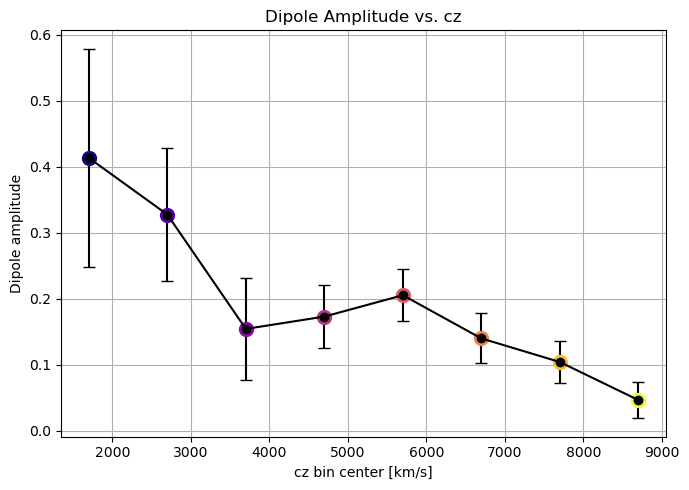

In [26]:
# === Dipole amplitude vs. cz plot ===
cz_bin_centers = []
dipole_amps = []
amp_errors = []
labels = []
colors = []
for label, res in dipole_results.items():
    if label == "Full Sample":
        continue  # Skip full sample in cz plot

    cz_range = label.split(" ")[0]  # e.g., "1200-2200"
    cz_min, cz_max = map(int, cz_range.split("-"))
    cz_center = 0.5 * (cz_min + cz_max)

    cz_bin_centers.append(cz_center)
    dipole_amps.append(res['d_perp'])
    amp_errors.append(res['σ_r'])  # using σ_r as proxy uncertainty
    labels.append(label)
    colors.append(res['color'])

# Plot
plt.figure(figsize=(7, 5))
plt.errorbar(cz_bin_centers, dipole_amps, yerr=amp_errors,
             fmt='o-', color='black', capsize=4)
for color, x, y in zip(colors, cz_bin_centers, dipole_amps):
    print(f"Plotting {x}, {y} with color {color}")
    plt.plot(x, y, marker='o', color=color, ms=10)

plt.xlabel("cz bin center [km/s]")
plt.ylabel("Dipole amplitude")
plt.title("Dipole Amplitude vs. cz")
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
for label, res in dipole_results.items():
    print(f"{label}: {res['color']}")
print(dipole_results.items())

Full Sample: gray
1200-2200 km/s: (0.050383, 0.029803, 0.527975, 1.0)
2200-3200 km/s: (0.32515, 0.006915, 0.639512, 1.0)
3200-4200 km/s: (0.546157, 0.038954, 0.64701, 1.0)
4200-5200 km/s: (0.723444, 0.196158, 0.538981, 1.0)
5200-6200 km/s: (0.85975, 0.360588, 0.406917, 1.0)
6200-7200 km/s: (0.95547, 0.533093, 0.28549, 1.0)
7200-8200 km/s: (0.994495, 0.74088, 0.166335, 1.0)
8200-9200 km/s: (0.940015, 0.975158, 0.131326, 1.0)
dict_items([('Full Sample', {'RA': 17.60231190031842, 'Dec': 57.20940928977971, 'r_alpha': 0.06803358425802633, 'd_perp': 0.059921320571354006, 'σ_r': 0.01579067662090882, 'σ_phi': 13.298419242511658, 'σ_dec': 13.298419242511658, 'Z': 3.7369386517582024, 'P': 9.313717430010804e-05, 'separation': 106.0497500867799, 'N': 8021, 'color': 'gray'}), ('1200-2200 km/s', {'RA': 176.3366053879358, 'Dec': -20.97749177550795, 'r_alpha': 0.9207074171768566, 'd_perp': 0.41346570806355615, 'σ_r': 0.1655211777204736, 'σ_phi': 10.300411103993826, 'σ_dec': 10.300411103993826, 'Z': 5.

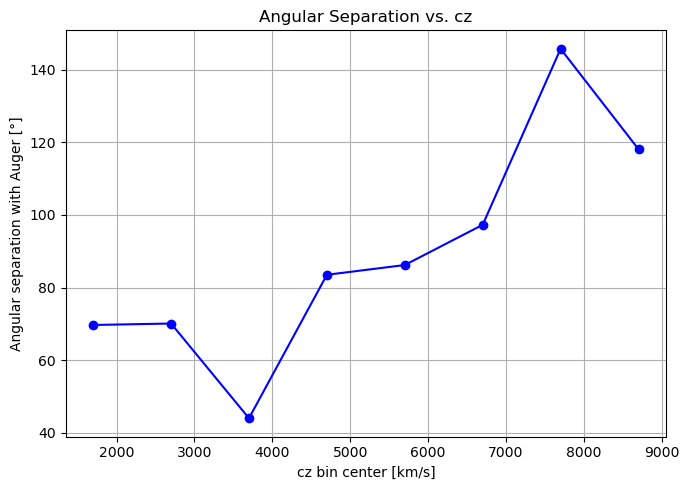

In [3]:
ang_sep = []
cz_bin_centers = []
for label, res in dipole_results.items():
    if label == "Full Sample":
        continue  # Skip full sample in cz plot

    cz_range = label.split(" ")[0]  # e.g., "1200-2200"
    cz_min, cz_max = map(int, cz_range.split("-"))
    cz_center = 0.5 * (cz_min + cz_max)

    cz_bin_centers.append(cz_center)
    ang_sep.append(res['separation'])

# Plot angular separation vs cz
plt.figure(figsize=(7, 5))
plt.plot(cz_bin_centers, ang_sep, marker='o', color='blue')
plt.xlabel("cz bin center [km/s]")
plt.ylabel("Angular separation with Auger [°]")
plt.title("Angular Separation vs. cz")
plt.grid(True)
plt.tight_layout()
plt.show()

    